                              Computer Vision Project


In [6]:
import os

# Path to training directory
train_dir = "/content/drive/MyDrive/Fruit.v1i.folder/train"

# List class names
class_names = sorted(os.listdir(train_dir))

print("Number of Classes:", len(class_names))
print("Class Names:")
for cls in class_names:
    print(cls)


Number of Classes: 10
Class Names:
apple
avocado
banana
cherry
kiwi
mango
orange
pinenapple
strawberries
watermelon


🔹: Visualize One Sample Image per Class

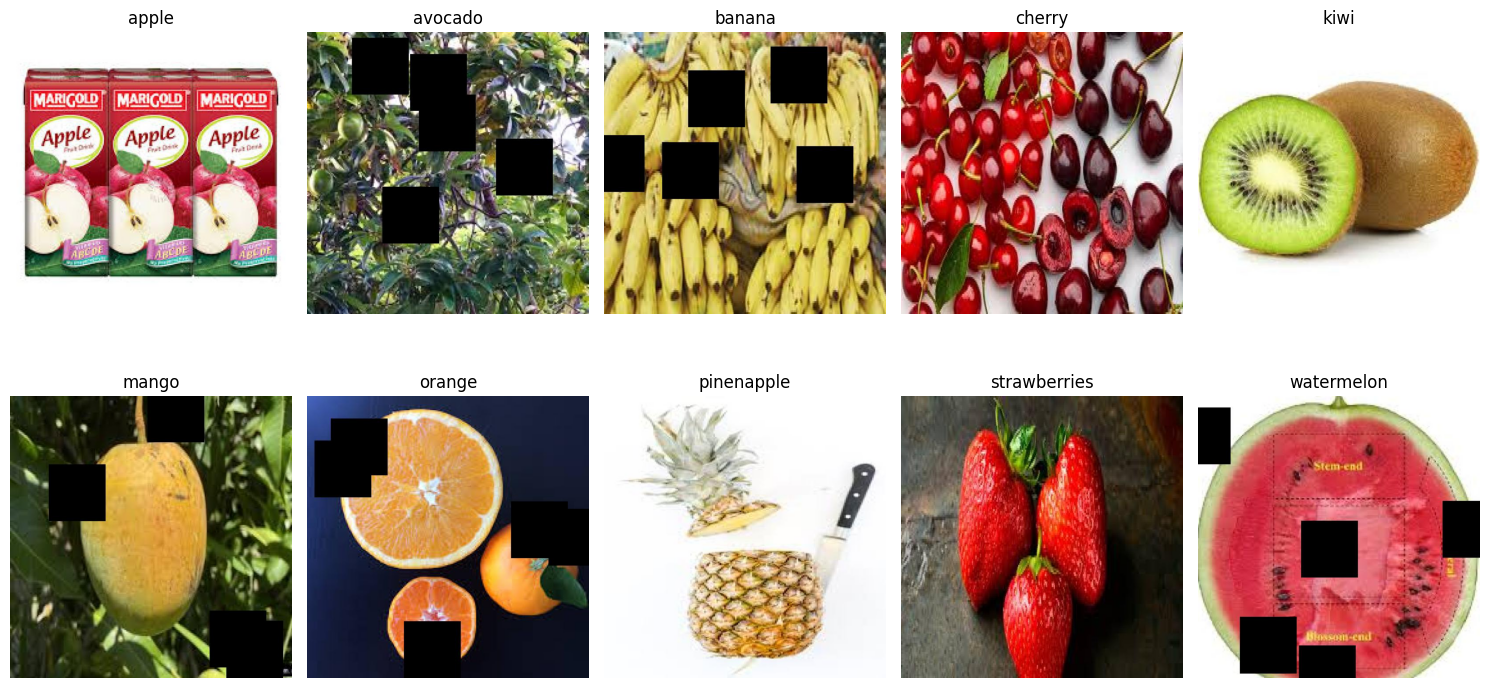

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize=(15, 8))

for i, cls in enumerate(class_names):
    class_path = os.path.join(train_dir, cls)

    # Pick first image from each class
    img_name = os.listdir(class_path)[0]
    img_path = os.path.join(class_path, img_name)

    img = Image.open(img_path)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()


                    📊 Phase 1: Data Exploration & Preprocessing

🔹 Task 1.1 (c): Class Distribution Plot

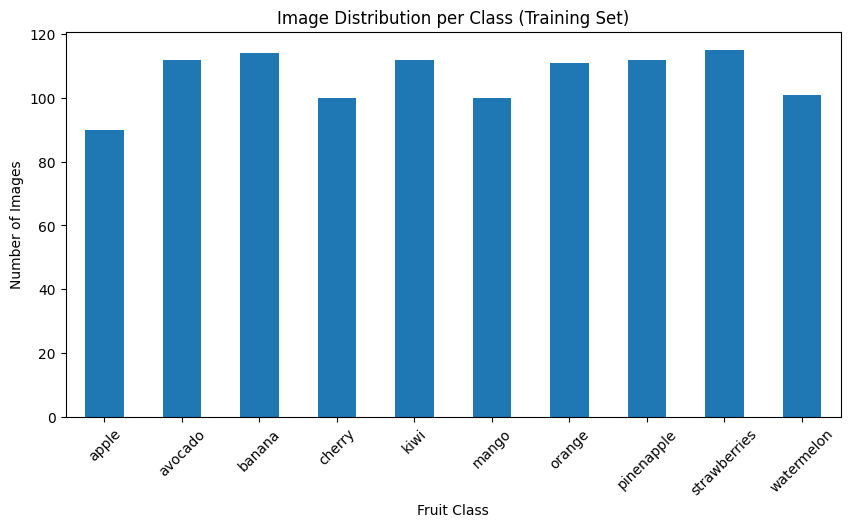

,Image_Count
apple,90
avocado,112
banana,114
cherry,100
kiwi,112
mango,100
orange,111
pinenapple,112
strawberries,115
watermelon,101


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

class_counts = {}

for cls in class_names:
    class_path = os.path.join(train_dir, cls)
    class_counts[cls] = len(os.listdir(class_path))

# Convert to DataFrame for easy plotting
df_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Image_Count'])

# Plot
plt.figure(figsize=(10, 5))
df_counts['Image_Count'].plot(kind='bar')
plt.title("Image Distribution per Class (Training Set)")
plt.ylabel("Number of Images")
plt.xlabel("Fruit Class")
plt.xticks(rotation=45)
plt.show()

df_counts


🔧 Phase 1: Preprocessing

🔹 Task 1.2: Image Resizing & Normalization

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Only rescaling (normalization)
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    "/content/drive/MyDrive/Fruit.v1i.folder/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

valid_gen = datagen.flow_from_directory(
    "/content/drive/MyDrive/Fruit.v1i.folder/valid",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = datagen.flow_from_directory(
    "/content/drive/MyDrive/Fruit.v1i.folder/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 1067 images belonging to 10 classes.
Found 205 images belonging to 10 classes.
Found 102 images belonging to 10 classes.


🔹 Task 1.3: Data Augmentation (Training Set Only)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Validation & Test (NO augmentation)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Fruit.v1i.folder/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

valid_gen = valid_test_datagen.flow_from_directory(
    "/content/drive/MyDrive/Fruit.v1i.folder/valid",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = valid_test_datagen.flow_from_directory(
    "/content/drive/MyDrive/Fruit.v1i.folder/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 1067 images belonging to 10 classes.
Found 205 images belonging to 10 classes.
Found 102 images belonging to 10 classes.


                Phase 2: Model Development - Transfer Learning (40 Points)


🔹 Task 2.1: Select a Pre-trained Model

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

# Load MobileNetV2 without top layers
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model
base_model.trainable = False

base_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

🔹 Task 2.3: Custom Classification Head

In [12]:
from tensorflow.keras import layers, models

# Number of classes
NUM_CLASSES = 10

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

🔹 Task 2.4: Compile & Train the Model

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [23]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 247s 7s/step - accuracy: 0.9386 - loss: 0.2118 - val_accuracy: 0.8634 - val_loss: 0.3890
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 552ms/step - accuracy: 0.9296 - loss: 0.1957 - val_accuracy: 0.8683 - val_loss: 0.3909
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 593ms/step - accuracy: 0.9203 - loss: 0.2223 - val_accuracy: 0.8488 - val_loss: 0.3987
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 547ms/step - accuracy: 0.9325 - loss: 0.2056 - val_accuracy: 0.8732 - val_loss: 0.3974


In [11]:
# model.save("/content/drive/MyDrive/fruit_mobilenet_model.keras")


In [16]:
# from tensorflow.keras.models import load_model

# model = load_model("/content/drive/MyDrive/fruit_mobilenet_model.keras")



Phase 4: Evaluation & Analysis (30 Points)



In [24]:
import numpy as np

# Predict probabilities for test set
y_pred_probs = model.predict(test_gen)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_gen.classes


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


🔹 Task 4.1: Quantitative Metrics

In [25]:
from sklearn.metrics import classification_report, accuracy_score

# Predict classes on test set
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes

# Test Accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"✅ Test Accuracy: {test_accuracy*100:.2f}%")

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("✅ Classification Report:\n", report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
✅ Test Accuracy: 86.27%
✅ Classification Report:
               precision    recall  f1-score   support

       apple       0.91      0.91      0.91        11
     avocado       0.86      1.00      0.92        12
      banana       1.00      0.75      0.86        12
      cherry       1.00      0.83      0.91         6
        kiwi       0.78      0.88      0.82         8
       mango       0.73      0.89      0.80         9
      orange       0.89      0.73      0.80        11
  pinenapple       0.77      1.00      0.87        10
strawberries       0.88      0.88      0.88         8
  watermelon       0.92      0.80      0.86        15

    accuracy                           0.86       102
   macro avg       0.87      0.87      0.86       102
weighted avg       0.88      0.86      0.86       102



🔹 Task 4.2(a): Training Curves (Accuracy & Loss)

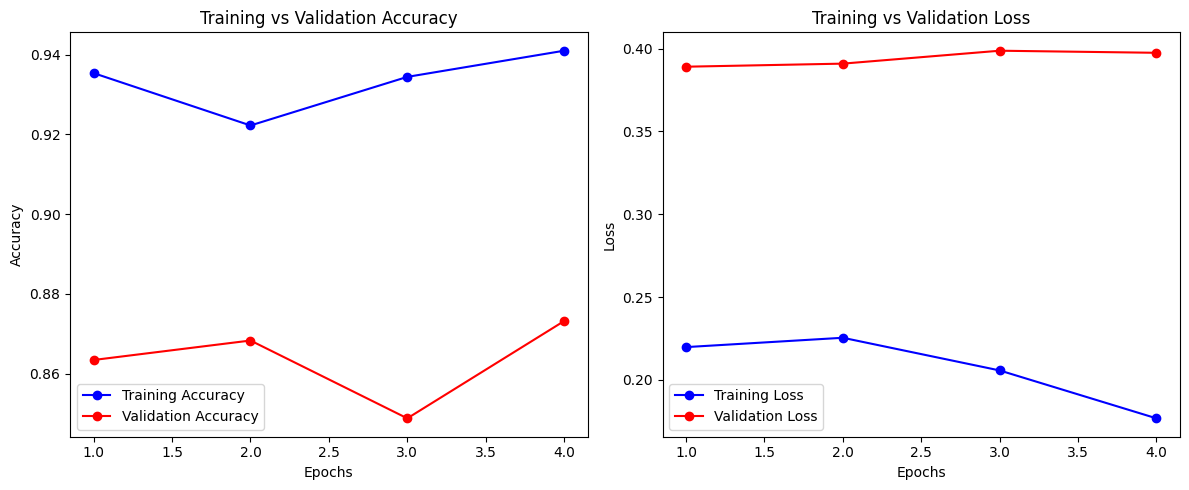

In [26]:
import matplotlib.pyplot as plt

# Extract metrics from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


🔹 Task 4.2: Confusion Matrix & Visualization

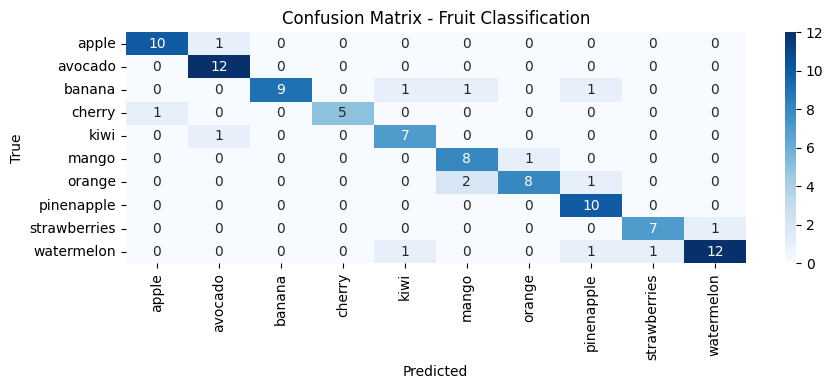

In [65]:
# 🧪 Code: Confusion Matrix & Heatmap

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Fruit Classification")
plt.show()


🧠 Phase 4: Error Analysis

🔹 Task 4.3: Display 5 Wrong Predictions

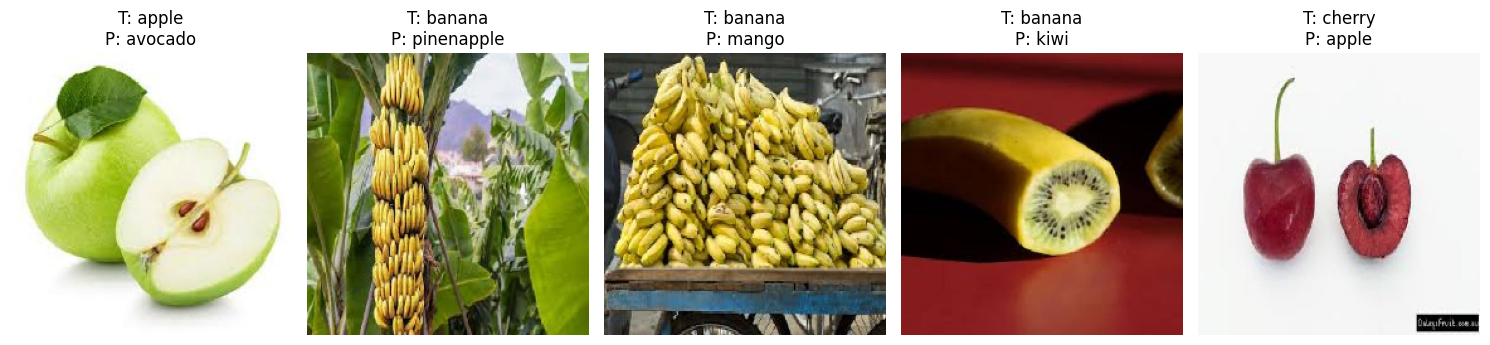

In [28]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Identify indices where predictions are wrong
wrong_indices = np.where(y_pred != y_true)[0]

# Display 5 wrong predictions
plt.figure(figsize=(15,6))

for i, idx in enumerate(wrong_indices[:5]):
    img_path = test_gen.filepaths[idx]
    img = image.load_img(img_path, target_size=(224, 224))

    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.axis('off')

    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]

    plt.title(f"T: {true_label}\nP: {pred_label}")

plt.tight_layout()
plt.show()


Brief Comments (Report)

Example comments for the 5 images:

1. green Apple → Predicted as avocado
Confusion due to similar color and small size

2. banana → Predicted as pipeapple
Confused due to hanging style

3. Banana → Predicted as Mango
Confused due to pattern on the fruit surface

4. Banana → Predicted as kiwi
Confused due to inner shape

5. Apple → Predicted as Cherry
Confusion because of similar round shape and color tone

                    
                    Phase 5: Deployment / Inference (15 Points)


In [29]:
#                 🧪 Code: Predict Function

from tensorflow.keras.preprocessing import image
import numpy as np

def predict_fruit(image_path):
    """
    Predict fruit class and confidence for a single image.

    Args:
        image_path (str): Path to the image file

    Returns:
        predicted_class (str)
        confidence (float)
    """
    # Load image
    img = image.load_img(image_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
    img_array /= 255.0  # normalize to 0-1

    # Predict
    preds = model.predict(img_array)
    pred_idx = np.argmax(preds)
    predicted_class = class_names[pred_idx]
    confidence = float(preds[0][pred_idx])

    print(f"Predicted Class: {predicted_class}, Confidence: {confidence*100:.2f}%")
    return predicted_class, confidence


In [33]:
# Usage

predict_fruit("/content/drive/MyDrive/Fruit.v1i.folder/test/banana/img_951_jpeg.rf.5fd3571d5f621250e9754ddff15559b1.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Class: banana, Confidence: 99.86%


('banana', 0.9985679388046265)

                                🧠 Phase 3: Fine-Tuning (Optional)

🔹 : Fine-Tune Model

In [60]:
# Step 1: Unfreeze top layers of base model
base_model.trainable = True
for layer in base_model.layers[:-15]:  # freeze all but last 20 layers
    layer.trainable = False

print("Number of trainable layers:", sum([layer.trainable for layer in base_model.layers]))

# Step 2: Recompile the model (VERY IMPORTANT)
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=3.7e-5),  # very low LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Step 3: Early stopping callback
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Step 4: Fine-tune model
fine_tune_history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=5,  # can increase to 10 if GPU time allows
    callbacks=[early_stop]
)

# Step 5: Save fine-tuned model
#model.save("/content/drive/MyDrive/fruit_mobilenet_model_finetuned.keras")
#print("✅ Fine-tuned model saved successfully!")


Number of trainable layers: 15
Epoch 1/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 938ms/step - accuracy: 0.9539 - loss: 0.1557 - val_accuracy: 0.8537 - val_loss: 0.3896
Epoch 2/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 614ms/step - accuracy: 0.9359 - loss: 0.1951 - val_accuracy: 0.8488 - val_loss: 0.3929
Epoch 3/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 39s 553ms/step - accuracy: 0.9712 - loss: 0.1341 - val_accuracy: 0.8537 - val_loss: 0.3938
Epoch 4/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 597ms/step - accuracy: 0.9712 - loss: 0.1246 - val_accuracy: 0.8537 - val_loss: 0.3921


Re-evaluation for Fine-Tuned Model

In [61]:
#🧪 Step 1: Predict on Test Set

import numpy as np

# Predict probabilities on test set
y_pred_probs_ft = model.predict(test_gen)

# Convert probabilities to class indices
y_pred_ft = np.argmax(y_pred_probs_ft, axis=1)

# True labels
y_true = test_gen.classes


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


In [62]:
# 🧪 Step 2: Test Accuracy & Classification Report

from sklearn.metrics import accuracy_score, classification_report

# Test Accuracy
test_accuracy_ft = accuracy_score(y_true, y_pred_ft)
print(f"✅ Fine-Tuned Test Accuracy: {test_accuracy_ft*100:.2f}%")

# Classification Report
report_ft = classification_report(y_true, y_pred_ft, target_names=class_names)
print("✅ Fine-Tuned Classification Report:\n", report_ft)


✅ Fine-Tuned Test Accuracy: 86.27%
✅ Fine-Tuned Classification Report:
               precision    recall  f1-score   support

       apple       0.91      0.91      0.91        11
     avocado       0.86      1.00      0.92        12
      banana       1.00      0.83      0.91        12
      cherry       1.00      1.00      1.00         6
        kiwi       0.78      0.88      0.82         8
       mango       0.80      0.89      0.84         9
      orange       0.89      0.73      0.80        11
  pinenapple       0.75      0.90      0.82        10
strawberries       0.78      0.88      0.82         8
  watermelon       0.92      0.73      0.81        15

    accuracy                           0.86       102
   macro avg       0.87      0.87      0.87       102
weighted avg       0.87      0.86      0.86       102



keras Tuner for Fine Tunning

In [63]:
!pip install keras-tuner -q

from kerastuner import HyperModel, RandomSearch
from tensorflow.keras.optimizers import Adam

class FruitHyperModel(HyperModel):
    def build(self, hp):
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
        base_model.trainable = False
        x = base_model.output
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(
            units=hp.Int('units', min_value=64, max_value=256, step=64),
            activation='relu'
        )(x)
        x = layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1))(x)
        outputs = layers.Dense(len(class_names), activation='softmax')(x)

        model = models.Model(base_model.input, outputs)
        model.compile(
            optimizer=Adam(hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

hypermodel = FruitHyperModel()

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=5,   # Number of combinations to try
    executions_per_trial=1,
    directory='fruit_tuning',
    project_name='mobilenet_tuning'
)

tuner.search(train_gen, validation_data=valid_gen, epochs=3)
best_model = tuner.get_best_models(num_models=1)[0]


Trial 5 Complete [00h 01m 25s]
val_accuracy: 0.21463415026664734

Best val_accuracy So Far: 0.8536585569381714
Total elapsed time: 00h 07m 08s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
